In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks, hough_line,\
                              hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import circle_perimeter, circle
from skimage.util import img_as_ubyte
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_local
from IPython.core.debugger import Tracer;

In [10]:
#Line Detection of a random picture from the picture folder
def detectLinesofRandPic():
    np.random.seed()
    idxs = np.random.randint(5228, 6162, size=1)
    for idx in idxs:
        image = imread('Preprocessed/IMG_{}.jpg'.format(idx), as_gray=True)
        edges = canny(image, sigma=5, low_threshold=0.01, high_threshold=0.2)
        hough_radii = np.arange(100, 600, 10)
        hough_res = hough_circle(edges, hough_radii)
        image = rgb2gray(image)
        edges = canny(image, sigma=3)
        lines = probabilistic_hough_line(edges, threshold=10, line_length=image.shape[0]//8,line_gap=3)
    return lines

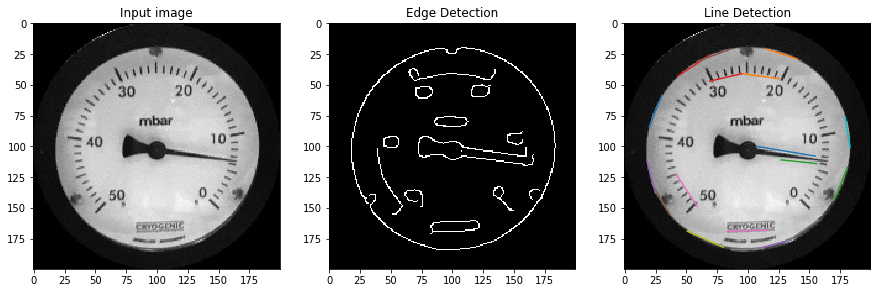

In [31]:
#Line Detection of a Specific Picture
def detectLinesofSpecificPic(idxs):
    image = imread('Preprocessed2/IMG_{}.jpg'.format(idxs), as_gray=True)
    edges = canny(image, sigma=5, low_threshold=0.01, high_threshold=0.2)
    hough_radii = np.arange(100, 600, 10)
    hough_res = hough_circle(edges, hough_radii)
    image = rgb2gray(image)
    edges = canny(image, sigma=3)
    lines = probabilistic_hough_line(edges, threshold=10, line_length=image.shape[0]//8,line_gap=3)
    ######
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    ax = axes.ravel()
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[1].imshow(edges, cmap=plt.cm.gray)
    ax[1].set_title('Edge Detection')
    ax[2].imshow(image, cmap=plt.cm.gray)
    ax[2].set_title('Line Detection')
    
    for line in lines:
        ax[2].plot((line[0][0],line[1][0]),(line[0][1],line[1][1]))
    return lines

_ = detectLinesofSpecificPic(5300)

In [12]:
#Filter Lines that only have coordinates close to the center
def filterLines(lines):
    FiltLines = []
    for ii in range(0,len(lines)):
        line=lines[ii]
        lx  =[line[0][0],line[1][0]]
        ly  =[line[0][1],line[1][1]]
        minRange = 75
        maxRange = 125
        if ((lx[0]>minRange)&(lx[0]<maxRange))&((ly[0]>minRange)&(ly[0]<maxRange))or((lx[1]>minRange)&(lx[1]<maxRange))&((ly[1]>minRange)&(ly[1]<maxRange)):
            FiltLines.append(line)
    return FiltLines

In [13]:
#Calculate the line angles and lengths. 
#Problem faced and solved: Get the lengths of the lines in addition to the angles to find the longest line
#Problem faced and solved: Make sure the line is pointing outwards from the centre
def calculateLineAngle(lines):
    angle =[]
    lineLength=[]
    maxii = len(lines)
    for ii in range(0,maxii):
        x1 = lines[ii][0][0]
        x2 = lines[ii][1][0]
        y1 = lines[ii][0][1]
        y2 = lines[ii][1][1]
        mul = 1
        one=np.array([100-x1,100-y1])
        two=np.array([100-x2,100-y2])
        if np.sqrt(one.dot(one)) > np.sqrt(two.dot(two)):
            mul = -1
            x2 = lines[ii][0][0]
            x1 = lines[ii][1][0]
        dx = x1 - x2
        dy = y1 - y2
        angle = np.append(angle,np.arctan2(dy,dx)*180/np.pi*mul)
        lineLength = np.append(lineLength,np.sqrt(abs(dx**2+dy**2)))
    return angle,lineLength

#Find longest line's angle using the returned line lenghts
def findLongestLineAngle(lines):
    A,L = calculateLineAngle(lines)
    LineIndex = np.argmax(L)
    return A[LineIndex],np.array(lines)[LineIndex]

In [14]:
#Visual Representation of what is going on
def plotFilteredLines(lines):
    minRange = 70
    maxRange = 130
    fiG, aXes = plt.subplots(1, 2, figsize=(15,5))
    aX = aXes.ravel()
    aX[0].imshow(np.zeros((200,200)))
    aX[1].imshow(np.zeros((200,200)))    
    filteredLines = filterLines(lines)
    aX[0].plot(((minRange,minRange,minRange,maxRange),(minRange,maxRange,maxRange,maxRange)),
               ((minRange,minRange,maxRange,minRange),(maxRange,minRange,maxRange,maxRange)))
    for line in filteredLines:
        aX[0].plot((line[0][0],line[1][0]),(line[0][1],line[1][1]))
    limer = findLongestLineAngle(filteredLines)
    lime = limer[1]
    aX[1].plot((lime[0][0],lime[1][0]),(lime[0][1],lime[1][1]))
    print("angle = " + str(limer[0]))
    plt.show()
    plt.tight_layout()

angle = 157.24902365721235


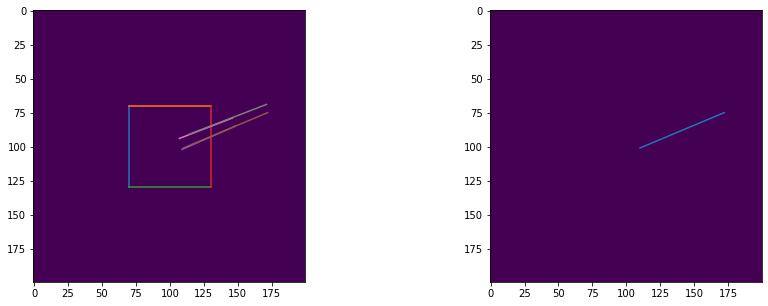

<Figure size 432x288 with 0 Axes>

In [20]:
#Try and see if this function works
lines = detectLinesofRandPic()
try:
    funArg = findLongestLineAngle(filterLines(lines))
except:
    print("break")
plotFilteredLines(lines)

In [6]:
#Problem faced and solved: Sometimes line detection would fail and break the loop, use try and except to mark the
#failed pictures
def GetAngle(idxs=0):
    if idxs == 0:
        np.random.seed()
        idxs = np.random.randint(5228, 6162, size=1)
    lines=detectLinesofSpecificPic(idxs)
    try:
        funArg = findLongestLineAngle(filterLines(lines))
    except:
        funArg = 'broken'
    return funArg[0]

In [7]:
#Problem faced and solved: the marked pictures created a problem in the neural net learning phase, so label them using 
#pictures nearby. The labeling should be fairly accurate since series pictures were taken
def fixB(col,data):
    for hh in range(0,len(data)):
        if np.isnan(data.iloc[hh][col]):
            j=0
            k=0
            try:
                while np.isnan(data.iloc[hh-j][col]):
                    j+=1
                upBound = data.iloc[hh-j][col]
                while np.isnan(data.iloc[hh+k][col]):
                    k+=1
                loBound = data.iloc[hh+k][col]
                data.at[hh,col]=((loBound-upBound)/(j+k))*j+upBound
            except:
                data.at[hh,col]=upBound

In [ ]:
# Write the labels to a csv file
filename = 'Degrees3.csv'
file = open(filename,"w")
file.write("Filename,Degree")
file.close()
for jj in range(5228, 6162):
    try:
        appendFile(filename,'IMG_{}.jpg'.format(jj),GetAngle([jj]))
    except:
        print('missing' + str(jj))


In [141]:
#Read csv file and fix the broken labels and add the gauge values in correct units (instead of angles)
data = pd.read_csv(filename,delimiter = ",",dtype = {'Filename': str,'Degree': np.float64}, na_values = 'b')
data['CorrectDegree']=(data['Degree']+90)%360
m = 50/(315-45) #mbar/deg
n = m*315-50
data['mbar']=m*(360-data['CorrectDegree'])-n
fixB('Degree',data)
fixB('CorrectDegree',data)
fixB('mbar',data)

In [143]:
#overwrite back the fixed csv file
data.to_csv(filename, sep=',')